In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from scipy.stats import norm, kurtosis, normaltest, probplot

from statsmodels.stats.diagnostic import kstest_normal, normal_ad, kstest_fit
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.gofplots import qqplot

import arch

from preprocess import Gaussianize
from metrics import emd_score, acf_score, le_score

from tqdm import tqdm


In [82]:

btc_data = pd.read_csv('../data/BTCUSD_1m_2015_01_01_now.csv')
btc_data['Timestamp'] = pd.to_datetime(btc_data['Timestamp'])
btc_data = btc_data.set_index('Timestamp')
btc_logret = np.log(btc_data['Close']).diff().resample('D').sum()


In [83]:
btc_logret = btc_logret[btc_logret.index <= '2021-05-01']

mu           2.479894
omega       62.822597
alpha[1]     0.153635
beta[1]      0.827792
Name: params, dtype: float64


100%|██████████| 2312/2312 [00:15<00:00, 147.87it/s]


loc: 0.000963, scale: 0.049103
kurtosis: 4.659685


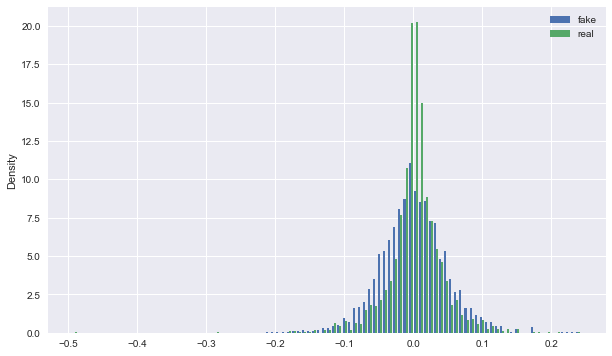

In [181]:
# %time
scaling = 1000
am = arch.arch_model(scaling * btc_logret)
res = am.fit(disp='off')
print(res.params)



#mu = 0
mu = res.params['mu']
omega = res.params['omega']
alpha = res.params['alpha[1]']
beta = res.params['beta[1]']

S = 250
M = 500

noise = norm.rvs(size=(btc_logret.shape[0], M))

sigma = np.zeros(M)[np.newaxis, :]
epsilon = np.array([])

epsilon = np.append(epsilon, noise[0] * sigma[-1])[np.newaxis, :]
fake = (mu + epsilon[-1])[np.newaxis, :]

for innovation in tqdm(noise[1:]):
     sigma = np.row_stack([sigma, np.sqrt((omega + alpha * epsilon[-1] ** 2 + beta * sigma[-1] ** 2))])
     epsilon = np.row_stack([epsilon, innovation * sigma[-1]])
     fake = np.row_stack([fake, mu + epsilon[-1]])

fake.shape



fake = np.array(fake) / scaling
loc, scale = norm.fit(fake[:, 0])
print(f'loc: {loc:.6f}, scale: {scale:.6f}')
print(f'kurtosis: {kurtosis(fake[:, 0], fisher=False):.6f}')
plt.figure(figsize=(10, 6))
plt.ylabel('Density')
plt.hist([fake[:, 0], btc_logret], bins=100, label=['fake', 'real'], density=True)
plt.legend()
plt.show()


In [186]:
fake_ret = fake.T

emd_1 = np.mean([emd_score(btc_logret, fake_ret[i, :]) for i in range(fake_ret.shape[0])])

acf_id = acf = acf_score(btc_logret, fake_ret, S)
acf_abs = acf = acf_score(btc_logret, fake_ret, S, np.abs)
acf_square = acf = acf_score(btc_logret, fake_ret, S, lambda x: x**2)
le = le_score(btc_logret, fake_ret, S)

print(f'Earth mover Distance: 1: {emd_1:.4f}'
 f'\nACF Score: id: {acf_id:.4f}, abs: {acf_abs:.4f}, square: {acf_square:.4f}  \nLeverage effect Score: {le:.4f}')

Earth mover Distance: 1: 0.0142
ACF Score: id: 0.3252, abs: 0.6366, square: 0.9497  
Leverage effect Score: 0.4124


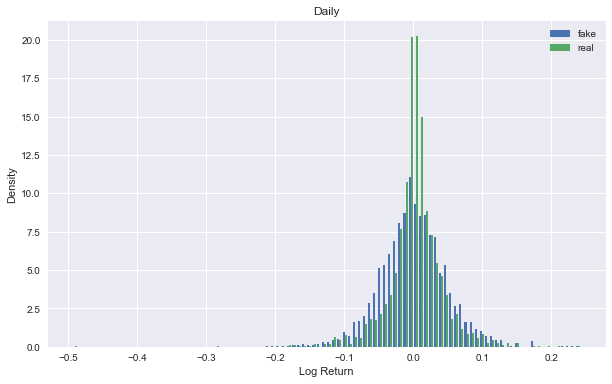

In [187]:

fig = plt.figure(figsize=(10, 6))
plt.style.use('seaborn')

ax1 = fig.add_subplot(1, 1, 1)
ax1.hist([fake_ret[0, :], btc_logret], bins=100, label=['fake', 'real'], density=True)
ax1.set_ylabel('Density')
ax1.set_xlabel('Log Return')
ax1.set_title('Daily')
ax1.legend()
plt.savefig('garch_density.pdf')
plt.show()

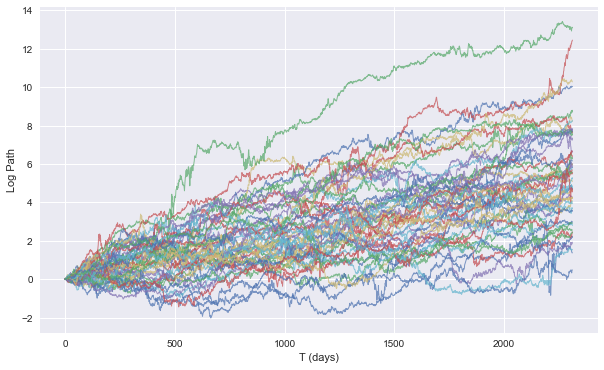

In [192]:
plt.figure(figsize=(10, 6))
plt.plot(fake.cumsum(axis=0)[:, :50], linewidth=1, alpha=0.7)
plt.ylabel('Log Path')
plt.xlabel('T (days)')
plt.savefig('Arch_paths.pdf')

## Trying fitting transformed version instead of log-rets

In [193]:
gauss = Gaussianize()
gauss.fit(btc_logret)
u = gauss.transform(btc_logret)

h:\My Drive\EPFL Account\ml4f\ml4f_project\src\preprocess.py:25: RuntimeWarning: invalid value encountered in true_divide
  return np.sign(z) * np.sqrt(np.real(lambertw(delta * z ** 2)) / delta)


7.374812474594102e-07 8


mu         -0.140226
omega       2.165450
alpha[1]    0.098139
beta[1]     0.881262
Name: params, dtype: float64


100%|██████████| 2312/2312 [00:15<00:00, 148.43it/s]


loc: 0.012630, scale: 0.952683
kurtosis: 5.241361


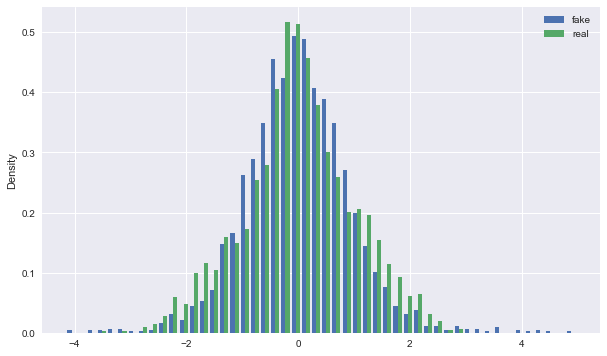

In [208]:
# %time
scaling = 10
am = arch.arch_model(scaling * u)
res = am.fit(disp='off')
print(res.params)



mu = 0
#mu = res.params['mu']
omega = res.params['omega']
alpha = res.params['alpha[1]']
beta = res.params['beta[1]']

S = 250
M = 500

noise = norm.rvs(size=(btc_logret.shape[0], M))

sigma = np.zeros(M)[np.newaxis, :]
epsilon = np.array([])

epsilon = np.append(epsilon, noise[0] * sigma[-1])[np.newaxis, :]
fake = (mu + epsilon[-1])[np.newaxis, :]

for innovation in tqdm(noise[1:]):
     sigma = np.row_stack([sigma, np.sqrt((omega + alpha * epsilon[-1] ** 2 + beta * sigma[-1] ** 2))])
     epsilon = np.row_stack([epsilon, innovation * sigma[-1]])
     fake = np.row_stack([fake, mu + epsilon[-1]])

fake.shape



fake = np.array(fake) / scaling
loc, scale = norm.fit(fake[:, 0])
print(f'loc: {loc:.6f}, scale: {scale:.6f}')
print(f'kurtosis: {kurtosis(fake[:, 0], fisher=False):.6f}')
plt.figure(figsize=(10, 6))
plt.ylabel('Density')
plt.hist([fake[:, 0], u], bins=50, label=['fake', 'real'], density=True)
plt.legend()
plt.show()


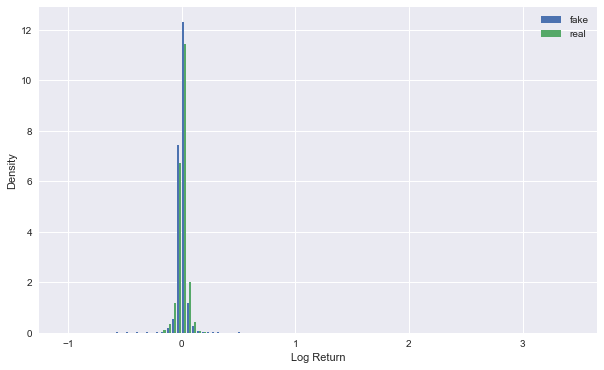

In [209]:
fake_ret = gauss.inverse_transform(fake)
plt.figure(figsize=(10, 6))
plt.ylabel('Density')
plt.xlabel('Log Return')
plt.hist([fake_ret[:, 0], btc_logret], bins=100, label=['fake', 'real'], density=True)
plt.legend()
plt.show()

In [210]:
fake_ret = fake.T

emd_1 = np.mean([emd_score(btc_logret, fake_ret[i, :]) for i in range(fake_ret.shape[0])])

acf_id = acf = acf_score(btc_logret, fake_ret, S)
acf_abs = acf = acf_score(btc_logret, fake_ret, S, np.abs)
acf_square = acf = acf_score(btc_logret, fake_ret, S, lambda x: x**2)
le = le_score(btc_logret, fake_ret, S)

print(f'Earth mover Distance: 1: {emd_1:.4f}'
 f'\nACF Score: id: {acf_id:.4f}, abs: {acf_abs:.4f}, square: {acf_square:.4f}  \nLeverage effect Score: {le:.4f}')

Earth mover Distance: 1: 0.7403
ACF Score: id: 0.3220, abs: 0.3846, square: 0.7013  
Leverage effect Score: 0.3900
